本章将会更深入地介绍NumPy库的数组计算。内容将包含更多的ndarray内部细节和更多高级数组操作和算法。

In [1]:
import numpy as np
import pandas as pd

# ndarray 对象内幕

NumPy的ndarray提供了一种方法将一组同构数据（连续的或跨步的）解释为多维数组对象。数据类型或dtype决定数据如何被解释为浮点数、整数、布尔值或正在查看的任何其他类型。

让ndarray如此灵活的部分原因是每个数组对象都是一个数据块的跨度视图。数组视图arr[::2, ::-1]能做到不复制任何数据的原因是ndarray不仅仅是一块内存和一个dtype，它还具有“跨步”信息，使数组能够以不同的步长在内存中移动。更确切地说，ndarray内部包含以下内容：
+ 指向数据的指针——即RAM中或内存映射文件中的数据块
+ 数据类型或dtype，描述数组中固定大小的值单元格
+ 表示数组形状（shape）的元组
+ 步长元组，表示要“步进”的字节数的整数以便沿维度推进一个元素

下图是ndarray内部结构：
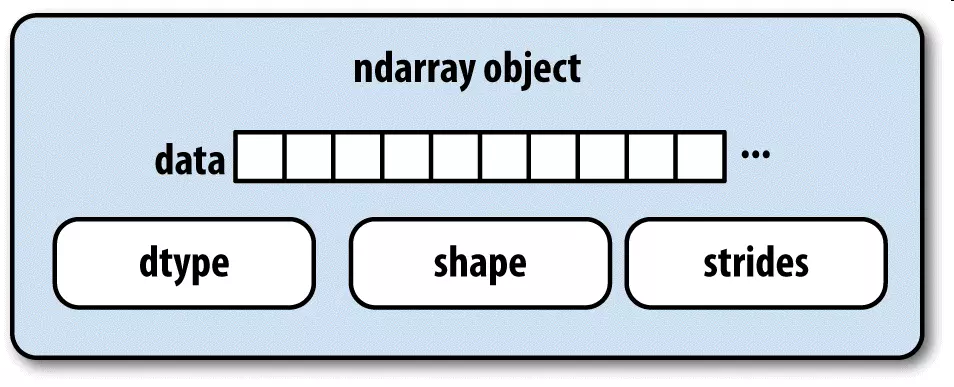

例如，一个10✖5的数组，其shape为（10，5）：

In [2]:
np.ones((10, 5)).shape

(10, 5)

一个典型的（C阶）3✖4✖5 float64 值（8字节）的数组具有跨度（160，40，8）（了解跨度可能是有用的，因为通常特定轴上的跨度越大，沿着该轴执行计算的代价越高）：

In [3]:
np.ones((3, 4, 5), dtype=np.float64).strides

(160, 40, 8)

虽然一般的NumPy用户很少会对数组跨度（strides）感兴趣，但它们是构建“零复制”数组驶入的关键因素。跨度甚至可以是负的，这使得数组能够穿过内存“向后”移动（例如，在诸如obj[::-1]或obj[:,::-1]的切片就是这种情况）。

## NumPy dtype 层次结构

在写代码时，偶尔会有检查数组是否包含整数、浮点数、字符串或Python对象。由于浮点数有多种类型（float16到float128），因此检查dtype是否在类型列表中会非常麻烦。但庆幸的是，dtype有**超类**，如np.integer和np.floating，它们可以和**np.issubdtype函数**一起使用：

In [4]:
ints = np.ones(10, dtype=np.uint16)
floats = np.ones(10, dtype=np.float32)
np.issubdtype(ints.dtype, np.integer)

True

In [5]:
np.issubdtype(floats.dtype, np.floating)

True

可以通过调用类型的**mro方法**来查看特定dtype的所有父类：

In [6]:
np.float64.mro()

[numpy.float64,
 numpy.floating,
 numpy.inexact,
 numpy.number,
 numpy.generic,
 float,
 object]

因此可以看到：

In [7]:
np.issubdtype(ints.dtype, np.number)

True

大部分NumPy用户不必知道这点，但知道了姐偶尔可以排上用场。下图是dtype的层次架构父类——子类关系图：

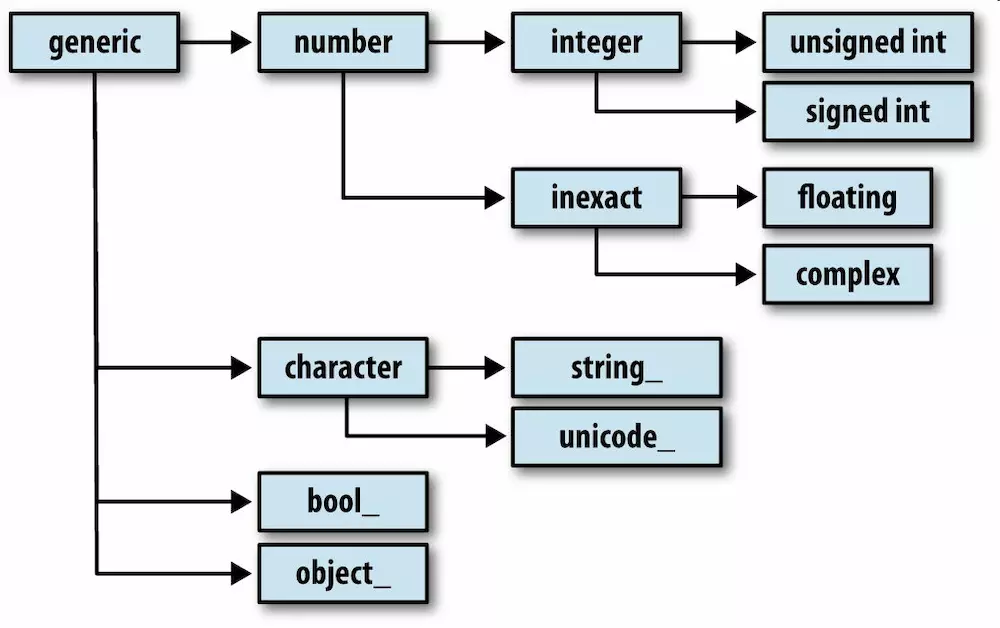

# 高阶数组操作

除了神奇索引、切片和布尔值子集外，还有很多方式可以处理数组。虽然大部分数据分析应用程序的繁重工作都是由pandas中的高级函数处理的，但有时可能需要编写一写在现有库中找不到的数据算法。

## 重塑数组

>数组重塑的过程：先变回原来的形状（1维数组），然后再根据所给的形状变化

在很多情况下，数组从一个形状转换为另一个形状，并且不复制任何数据。为了实现这个功能，可以向reshape数组实例方法传递一个表示新形状的元组。例如，假设有一个一维数组，想要把该数组重新排列进一个矩阵，结果如下图所示：

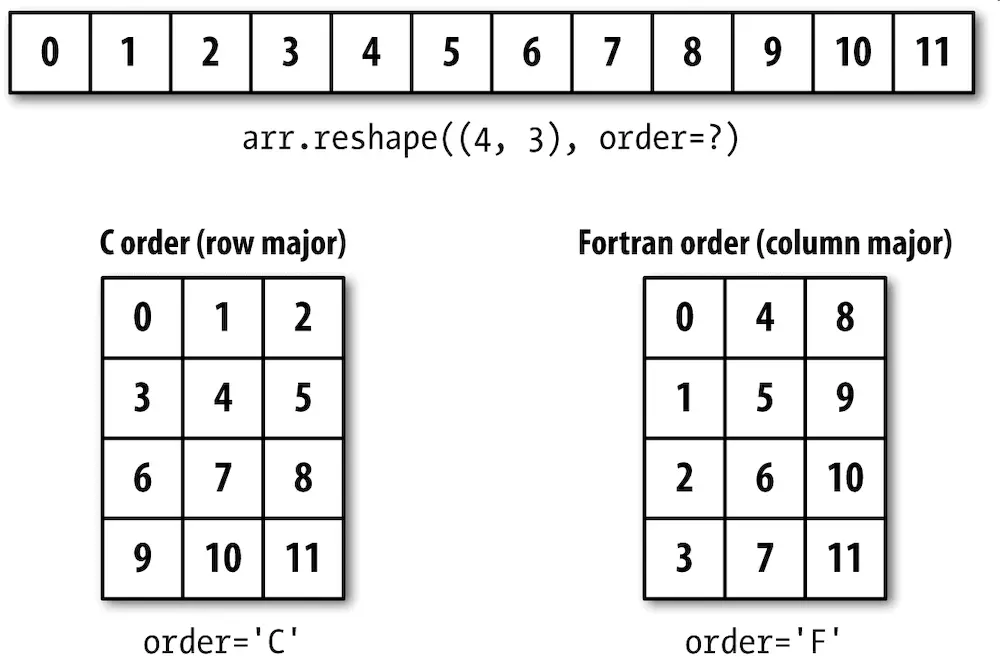

>C顺序：按行方向重塑；  
>Fortran顺序：按列方向重塑

In [4]:
arr = np.arange(8)
arr

array([0, 1, 2, 3, 4, 5, 6, 7])

In [5]:
arr.reshape((4,2))

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

多维数组也可以被重塑：

In [13]:
arr.reshape((4, 2)).reshape((2, 4),order='F')

array([[0, 4, 1, 5],
       [2, 6, 3, 7]])

传递的形状维度可以有一个值是-1，表示维度通过数据进行推断：

In [11]:
arr = np.arange(15)
arr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [12]:
arr.reshape((5, -1))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

由于数组属性是一个元组，它也可以被传递给reshape：

In [13]:
other_arr = np.ones((3,5))
other_arr.shape

(3, 5)

In [14]:
arr.reshape(other_arr.shape)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

reshape的反操作可以将更高维度的数组转换为一维数组，这种操作通常被称为扁平化（flattening）或分散化（raveling）：
+ ravel方法、flatten方法

In [15]:
arr = np.arange(15).reshape((5,3))
arr

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [16]:
arr.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

如果结果中的值在原始数组中是连续的，则ravel不会生成底层数值的副本。flatten方法的行为类似于ravel，但总是返回数据的副本：

In [17]:
arr.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

数据可以按照不同的顺序进行重塑或扁平化。

## C顺序和Fortran顺序

NumPy允许更为灵活地控制数据在内存中的布局。默认情况下，NumPy数组是按行方向顺序创建的。在空间上，这意味着如果有一个二维数组，数组每行中的元素存储在相邻的内存位置上。行方向顺序的替代方法是列方向顺序，这意味着每列数据中的值都存储在相邻的内存位置上。

C顺序表示行方向上的顺序，Fortran顺序表示列方向上的顺序。

像reshape和ravel函数都可以接收一个order参数，该参数表示数据在数组中使用哪种顺序。大部分情况下，该参数可以被设置为“C”或“F”（还有一些不太常用的选项“A”和“K”）。

In [18]:
arr = np.arange(12).reshape((3,4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [19]:
arr.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [20]:
arr.ravel('F')

array([ 0,  4,  8,  1,  5,  9,  2,  6, 10,  3,  7, 11])

对二维以上的数组重塑可能会令人费解。C顺序和Fortran顺序的核心区别就是在维度方向上遍历的方式：

C顺序/行方向顺序
    首先遍历更高维度（例如，在轴0上行进之前先在轴1上行进）
Fortran顺序/列方向顺序
    最后遍历更高的维度（例如，在轴1上行进之前先在轴0上行进）

## 数组的合并与拆分

numpy.concatenate可以获取数组的序列（元组、列表等），并沿着数组周将它们按顺序谅解在一起：

In [21]:
arr1 = np.array([[1,2,3],[4,5,6]])
arr2 = np.array([[7,8,9],[10,11,12]])
np.concatenate([arr1,arr2], axis=0)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

对于常见的连接类型有一些方便的函数，比如vstack和hstack。之前的操作也可以这样表达：

In [22]:
np.vstack([arr1, arr2])
#垂直

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [23]:
np.hstack((arr1,arr2))
#水平

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

**split函数**可以将以个数组沿轴方向分割维多个数组：

In [24]:
arr = np.random.randn(5,2)
arr

array([[-1.00702871, -0.76627724],
       [ 0.48043329, -0.34616816],
       [ 1.34815549,  1.01007739],
       [ 0.82017933,  0.70883568],
       [ 0.49152094, -0.05230111]])

In [25]:
first, second, third = np.split(arr,[1,3])
first

array([[-1.00702871, -0.76627724]])

In [26]:
second

array([[ 0.48043329, -0.34616816],
       [ 1.34815549,  1.01007739]])

In [27]:
third

array([[ 0.82017933,  0.70883568],
       [ 0.49152094, -0.05230111]])

传递给np.split的值\[1, 3\]表示将数组拆分的索引位置。

下表是全部与关连接和分割的函数列表，其中一些仅作为通用concatenate的便捷方法：

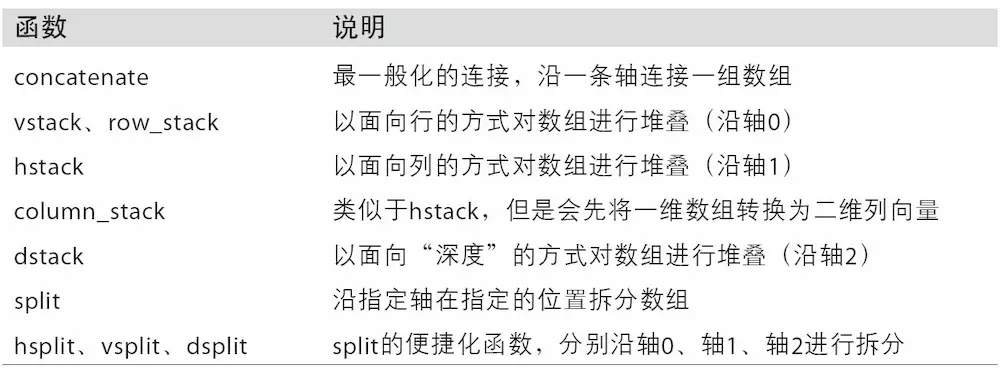

### 堆叠助手：r_和c_

再NumPy命名空间中有两个特殊的对象：r_和c_，它们可以是堆栈数组的操作更为简洁：

In [28]:
arr = np.arange(6)
arr1 = arr.reshape((3,2))
arr2 = np.random.randn(3,2)
np.r_[arr1,arr2]

array([[ 0.        ,  1.        ],
       [ 2.        ,  3.        ],
       [ 4.        ,  5.        ],
       [-2.17190799, -1.35765499],
       [-1.3743936 ,  0.45334951],
       [-0.78016033,  0.63651607]])

In [29]:
np.c_[np.r_[arr1,arr2],arr]

array([[ 0.        ,  1.        ,  0.        ],
       [ 2.        ,  3.        ,  1.        ],
       [ 4.        ,  5.        ,  2.        ],
       [-2.17190799, -1.35765499,  3.        ],
       [-1.3743936 ,  0.45334951,  4.        ],
       [-0.78016033,  0.63651607,  5.        ]])

这些函数还可以将切片转换维数组：

In [30]:
np.c_[1:6,-10:-5]

array([[  1, -10],
       [  2,  -9],
       [  3,  -8],
       [  4,  -7],
       [  5,  -6]])

看官方文档可以了解更多c_和r_的功能。

## 重复元素：tile和repeat

**repeat和tile函数**是用于重复和赋值数组的两个有用的工具。repeat函数按照给定次数对数组中的每个元素进行复制，生成一个更大的数组：

In [31]:
arr = np.arange(3)
arr

array([0, 1, 2])

In [ ]:
list(arr)

In [32]:
arr.repeat(3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

>对于NumPy而言，复制或重复数组的需求可能不如其他数组编程框架（如MATLAB）那样常见。其中一个原因是广播通常会更好地满足这一需求。

默认情况下，如果传递一个整数，每个元素都会复制相应的次数。如果传递了一个整数数组，每个元素都会重复相应的不同次数：

In [33]:
arr.repeat([2,3,4])

array([0, 0, 1, 1, 1, 2, 2, 2, 2])

多维数组可以在指定的轴向上对它们的元素进行重复：

In [34]:
arr = np.random.randn(2,2)
arr

array([[1.6645038 , 0.21865978],
       [0.81547159, 0.33412244]])

In [35]:
arr.repeat(2,axis=0)

array([[1.6645038 , 0.21865978],
       [1.6645038 , 0.21865978],
       [0.81547159, 0.33412244],
       [0.81547159, 0.33412244]])

注意，如果没有传递轴，数组将首先扁平化。同样，在需要按照不同次数重复多维数组的切片时，也可以传递一个整数数组：

In [36]:
arr.repeat([2,3],axis=0)

array([[1.6645038 , 0.21865978],
       [1.6645038 , 0.21865978],
       [0.81547159, 0.33412244],
       [0.81547159, 0.33412244],
       [0.81547159, 0.33412244]])

In [37]:
arr.repeat([2,3],axis=1)

array([[1.6645038 , 1.6645038 , 0.21865978, 0.21865978, 0.21865978],
       [0.81547159, 0.81547159, 0.33412244, 0.33412244, 0.33412244]])

另一方面，tile是一种快捷方法，它可以沿着轴向堆叠副本。在视觉上，可以把它看作类似于“铺设瓷砖”：

In [38]:
arr

array([[1.6645038 , 0.21865978],
       [0.81547159, 0.33412244]])

In [39]:
np.tile(arr,2)

array([[1.6645038 , 0.21865978, 1.6645038 , 0.21865978],
       [0.81547159, 0.33412244, 0.81547159, 0.33412244]])

第二个参数是“瓷砖”的数量。用标量来说，铺设是逐行进行的，而不是逐列。tile的而各参数还可以是表示“铺瓷砖”布局的元组：

In [40]:
arr

array([[1.6645038 , 0.21865978],
       [0.81547159, 0.33412244]])

In [41]:
np.tile(arr,(2,1))

array([[1.6645038 , 0.21865978],
       [0.81547159, 0.33412244],
       [1.6645038 , 0.21865978],
       [0.81547159, 0.33412244]])

In [42]:
np.tile(arr,(3,2))

array([[1.6645038 , 0.21865978, 1.6645038 , 0.21865978],
       [0.81547159, 0.33412244, 0.81547159, 0.33412244],
       [1.6645038 , 0.21865978, 1.6645038 , 0.21865978],
       [0.81547159, 0.33412244, 0.81547159, 0.33412244],
       [1.6645038 , 0.21865978, 1.6645038 , 0.21865978],
       [0.81547159, 0.33412244, 0.81547159, 0.33412244]])

## 神奇索引的等价方法：take和put

之前已经学过使用整数数组通过神奇索引获取、设置数组子集：

In [43]:
arr = np.arange(10) * 100
inds = [7, 1, 2, 6]
arr[inds]

array([700, 100, 200, 600])

还有一些ndarray方法可以用于特殊情况下在单个轴上的数据选取：

In [44]:
arr.take(inds)

array([700, 100, 200, 600])

In [45]:
arr.put(inds, 42)
arr

array([  0,  42,  42, 300, 400, 500,  42,  42, 800, 900])

In [46]:
arr.put(inds,[40,41,42,43])
arr

array([  0,  41,  42, 300, 400, 500,  43,  40, 800, 900])

如果要在别的轴上使用take，可以传递axis关键字：

In [47]:
inds = [2, 0, 2, 1]
arr = np.random.randn(2,4)
arr

array([[ 0.92007666,  2.01405151,  0.47736143, -0.8188724 ],
       [-1.68721838,  1.22228115,  0.17011411, -1.60676123]])

In [48]:
arr.take(inds,axis=1)

array([[ 0.47736143,  0.92007666,  0.47736143,  2.01405151],
       [ 0.17011411, -1.68721838,  0.17011411,  1.22228115]])

put不接受axis参数，而是将数组索引到扁平版本（一维，C顺序）。因此，当需要使用其他轴上的索引数组设置元素时，通常最容易使用神奇索引。

# 广播

广播描述了算法如何在不同形状的数组之间进行运算。它是一个强大的功能，但可能会导致混淆，即使对于有经验的用户也是如此。最简单的广播发生在将标量值与数组组合的时候：

In [49]:
arr = np.arange(5)
arr

array([0, 1, 2, 3, 4])

In [50]:
arr * 4

array([ 0,  4,  8, 12, 16])

这里的标量值4就已经被广播乘给乘法运算中的所有元素。

例如，可以通过减去列均值来降低数组中的每一列的数值。使用广播后，非常简单：

In [51]:
arr = np.random.randn(4,3)
arr.mean(0)

array([0.65517432, 0.15365032, 0.2870471 ])

In [52]:
demeaned = arr - arr.mean(0)
demeaned

array([[-0.77738405,  0.94391826,  0.19763619],
       [ 1.10765271, -0.19332773,  0.56922143],
       [-0.79050887, -0.02530871, -0.31882519],
       [ 0.46024021, -0.72528181, -0.44803243]])

In [53]:
demeaned.mean(0)

array([ 2.77555756e-17, -2.77555756e-17,  0.00000000e+00])

下图形象地展示了这个过程。对行进行减均值的广播需要更加小心。幸运的是，只要遵循规则，就可以在数组的任何维度上对潜在较低维度值进行广播（例如从二维数组的每一列中减去行均值）。

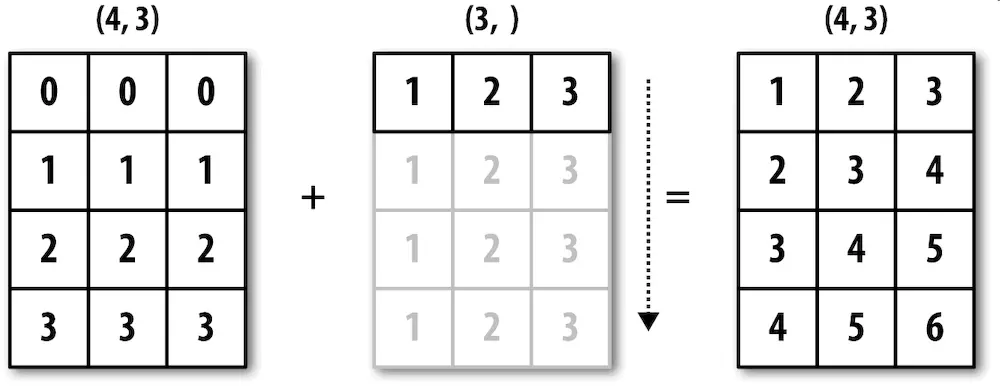

于是有：

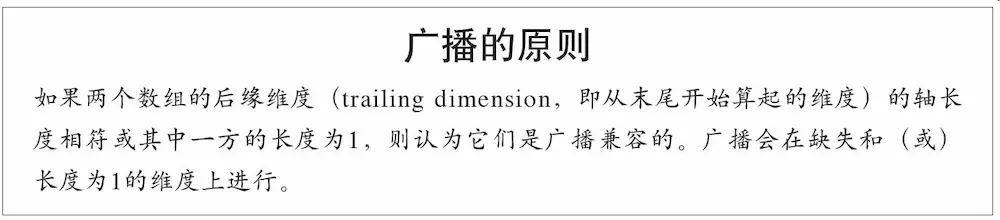

再来看一下上个例子，假设希望减去每一行的均值。由于arr.mean(0)的长度为3，因此它与轴0上的广播兼容，因为arr中的结尾维度为3，因此匹配。

根据这个规则，要在1轴上减去均值（即从每行减去平均值），较小的数组的形状必须是（4，1）：

In [54]:
arr

array([[-0.12220973,  1.09756857,  0.4846833 ],
       [ 1.76282703, -0.03967741,  0.85626854],
       [-0.13533455,  0.1283416 , -0.03177809],
       [ 1.11541453, -0.57163149, -0.16098533]])

In [55]:
row_means = arr.mean(1)
row_means.shape

(4,)

In [56]:
row_means.reshape((4,1))

array([[ 0.48668071],
       [ 0.85980605],
       [-0.01292368],
       [ 0.12759924]])

In [57]:
demeaned = arr - row_means.reshape((4,1))
demeaned.mean(1)

array([-1.85037171e-17, -3.70074342e-17, -2.31296463e-18,  3.70074342e-17])

下图显示了这个操作：

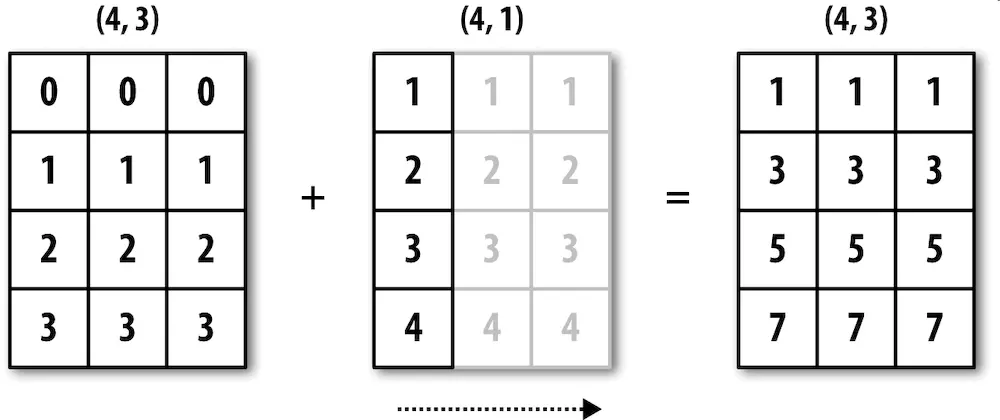

下图是对沿着轴0将一个二维数组加到三维数组的示意：

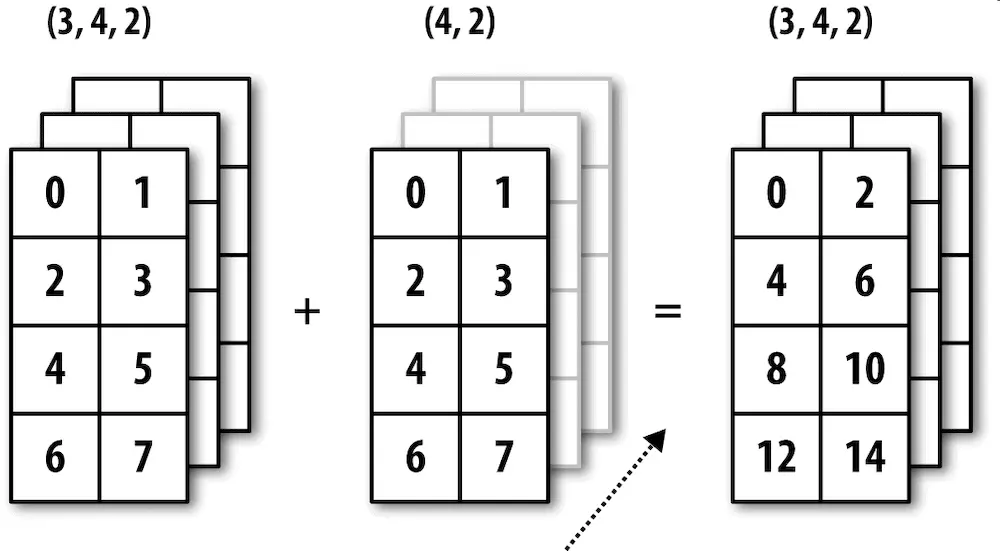

## 在其他轴上广播

使用更高维度的数组进行广播会更加令人头疼，但这确实是遵循规则的问题。如你不这样做，会得到这样的错误：

In [58]:
arr - arr.mean(1)

ValueError: operands could not be broadcast together with shapes (4,3) (4,) 

想要在轴0以外的轴上使用较低维数组进行算术运算是相当普遍的。根据广播规则，**`“广播维度”在较小的数组中必须为1。`**在这里显示的行均值的例子中，这表示重新塑造行意味着形状是（4，1）而不是（4，）：

In [59]:
arr - arr.mean(1).reshape((4,1))

array([[-0.60889045,  0.61088786, -0.00199742],
       [ 0.90302098, -0.89948346, -0.00353751],
       [-0.12241087,  0.14126528, -0.01885441],
       [ 0.98781529, -0.69923073, -0.28858456]])

在三维情况下，在三个维度中的任何一个维度上进行广播只是将数据重塑为形状兼容的问题。下图很好地显示了在三维数组的每个轴上广播所需的形状：

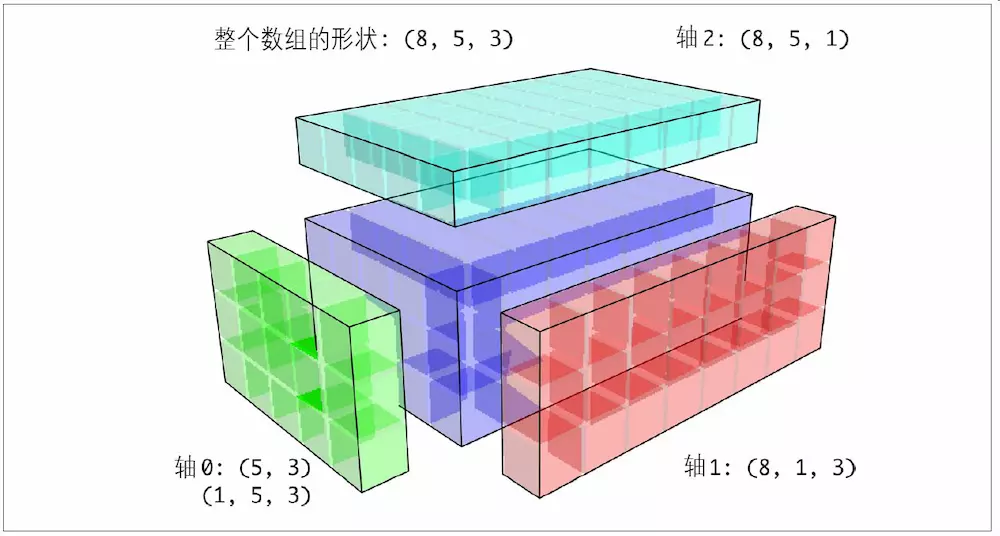

因此，一个常见的问题是需要添加一个专门用于广播目的长度为1的新轴。使用reshape是一种选择。但插入一个轴需要构造一个表示新形状的元组。这通常是一个乏味的练习。因此，NumPy数组提供了一种通过索引插入新轴的特殊语法。使用符号**np.newaxis**属性和“完整”切片的插入新轴：

In [60]:
arr = np.zeros((4,4))
arr_3d = arr[:, np.newaxis, :]
arr_3d.shape

(4, 1, 4)

In [61]:
arr_1d = np.random.normal(size=3)
arr_1d[:, np.newaxis]

array([[-0.36437182],
       [-0.42969102],
       [-0.76300834]])

In [62]:
arr_1d[np.newaxis, :]

array([[-0.36437182, -0.42969102, -0.76300834]])

因此，如果有一个三维数组并想在轴2上减去均值，可以这样写：

In [63]:
arr = np.random.randn(3,4,5)
depth_means = arr.mean(2)
depth_means

array([[ 0.28414767, -0.53018255,  0.23186437, -0.2044696 ],
       [ 0.67736668,  0.4941026 , -0.2494957 , -0.2650385 ],
       [ 0.69679805, -0.91405193,  1.43519382, -0.73276632]])

In [64]:
depth_means.shape

(3, 4)

In [65]:
demeaned = arr - depth_means[:,:,np.newaxis]
demeaned.mean(2)

array([[ 0.00000000e+00,  0.00000000e+00, -4.44089210e-17,
        -4.44089210e-17],
       [ 0.00000000e+00,  0.00000000e+00, -2.22044605e-17,
         8.88178420e-17],
       [-4.44089210e-17,  8.88178420e-17, -1.33226763e-16,
        -4.44089210e-17]])

有些读者可能会想，对于在对指定轴进行减去均值的操作，有没有一种既通用又不牺牲性能的方法呢？实际上是有的，但需要一些索引方面的技巧： 

In [66]:
def demeaned_axis(arr, axis=0):
    means = arr.mean(axis)
    # 将形如[:,:,np.newaxis]的对象推广到N维
    indexer = [slice(None)] * arr.ndim 
    # 这一步就形成了[:,:,np.newaxis]
    indexer[axis] = np.newaxis
    return arr - means[indexer]

>注意**slice**的用法

## 通过广播设定数组的值

**控制算术运算的相同广播规则也适用于通过数组索引设置值。**在一个简单的例子中，可以这样做：

In [67]:
arr = np.zeros((4,3))
arr[:] = 5
arr

array([[5., 5., 5.],
       [5., 5., 5.],
       [5., 5., 5.],
       [5., 5., 5.]])

但是，如果想要将数量的一维数组设置到数组的列中，只要形状是兼容的就可以做到这一点：

In [68]:
col = np.array([1.28, -0.42, 0.44, 1.6])
arr[:] = col[:, np.newaxis]
arr

array([[ 1.28,  1.28,  1.28],
       [-0.42, -0.42, -0.42],
       [ 0.44,  0.44,  0.44],
       [ 1.6 ,  1.6 ,  1.6 ]])

In [69]:
arr[:2] = [[-1.37],[0.509]]
arr

array([[-1.37 , -1.37 , -1.37 ],
       [ 0.509,  0.509,  0.509],
       [ 0.44 ,  0.44 ,  0.44 ],
       [ 1.6  ,  1.6  ,  1.6  ]])

# 高阶ufunc用法

虽然许多NumPy用户只会使用通用函数提供的按元素操作，但还有一些额外的功能偶尔可以帮助编写更简洁的代码而无须循环。

## ufunc实例方法

NumPy的每个二元ufunc（通用函数）都有特殊的方法来执行某些特殊的向量化操作。下表总结了这些内容，并举几个具体的示例来说明它们的工作原理：

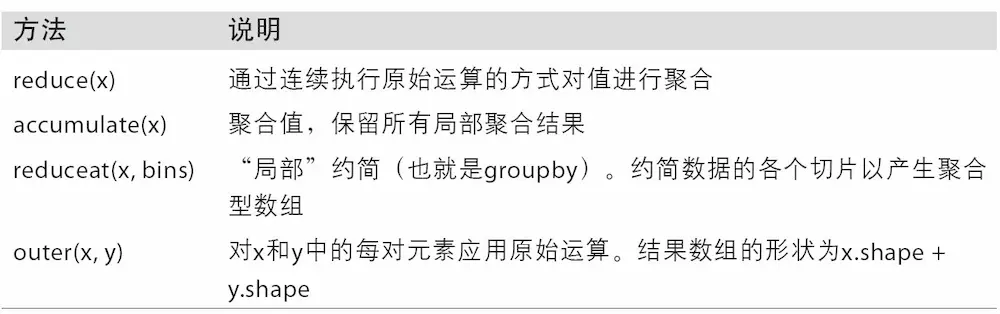

reduce方法接收单个数组并通过在可选的轴上选的轴向上执行一系列二元操作对数组的值进行聚合。例如，使用np.add.reduce是对数组中元素进行加和的另一种方法：

In [70]:
arr = np.arange(10)
np.add.reduce(arr)

45

In [71]:
arr.sum()

45

起始值（对于add方法是0）取决于ufunc。如果传递了一个轴，则沿该轴执行缩聚。这使得能够以简洁的方式回答某些种类的问题。在下面的例子中，可以使用np.logical_and来键差数组的每一行中过的值是否被排斥：

In [72]:
np.random.seed(123456) #为了可以复现

In [14]:
arr = np.random.randn(5,5)
arr[::2].sort(1) # 对行排序
# np.sort(a, axis=-1, kind='quicksort', order=None)
# 按最高维度分别排序
arr[:,:-1] < arr[:,1:]

array([[ True,  True,  True,  True],
       [ True,  True, False, False],
       [ True,  True,  True,  True],
       [ True,  True, False,  True],
       [ True,  True,  True,  True]])

In [20]:
np.logical_and.reduce(arr[:,:-1] < arr[:,1:], axis=1)

array([ True, False,  True, False,  True])

>请注意：np.logical_and.reduce等价于all方法，np.logical_or.reduce等价于any方法

accumulate与reduce是相关的，就像cumsum与宿命相关一样。accumulate生成一个数组，其尺寸与中间“累计”值相同：

In [75]:
arr = np.arange(15).reshape((3, 5))
np.add.accumulate(arr, axis=1)

array([[ 0,  1,  3,  6, 10],
       [ 5, 11, 18, 26, 35],
       [10, 21, 33, 46, 60]], dtype=int32)

outer在两个数组之间执行成对的交叉乘积：

In [76]:
arr = np.arange(3).repeat([1,2,2])
arr

array([0, 1, 1, 2, 2])

In [77]:
np.multiply.outer(arr, np.arange(5))

array([[0, 0, 0, 0, 0],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 2, 4, 6, 8],
       [0, 2, 4, 6, 8]])

outer的输出的维度等于输入的维度总和：

In [78]:
x, y = np.random.randn(3, 4), np.random.randn(5)
result = np.subtract.outer(x,y)
result.shape

(3, 4, 5)

最后一个方法reduceat执行“本地缩聚”，本质上是一个数组groupby操作，在操作中数组的切片聚合在了一起。reduceat方法接受一系列的“箱体边缘”，这些箱体边缘表示如何分隔以及聚合数据值：

In [79]:
arr = np.arange(10)
np.add.reduceat(arr, [0, 5, 8])

array([10, 18, 17], dtype=int32)

结果是在arr\[0:5\]\、arr\[5:8\]和arr\[8:\]上执行了缩聚（此处加和）。在其他方法中，可以传递一个axis参数：

In [80]:
arr = np.multiply.outer(np.arange(4), np.arange(5))
arr

array([[ 0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4],
       [ 0,  2,  4,  6,  8],
       [ 0,  3,  6,  9, 12]])

In [81]:
np.add.reduceat(arr, [0,2,4], axis=1)

array([[ 0,  0,  0],
       [ 1,  5,  4],
       [ 2, 10,  8],
       [ 3, 15, 12]], dtype=int32)

## 使用Python编写新的ufunc方法
+ np.frompyfunc
+ np.vectorize

有很多工具可以用于创建自定义的NumPy ufunc，最常用的是NumPy的C语言API，但是它已经超出了本书的范畴。在本节，只是一起看看纯Python的 ufunc方法。

numpy.frompyfunc函数接收一个具有特定数字输入和输出的函数。例如，一个简单的按元素相加的函数可以如下：

In [82]:
def add_elements(x, y):
    return x + y

In [83]:
add_them = np.frompyfunc(add_elements, 2, 1)
add_them(np.arange(8),np.arange(8))

array([0, 2, 4, 6, 8, 10, 12, 14], dtype=object)

>np.frompyfunc(func,nin,nout)  
>采用任意Python函数并返回一个NumPy ufunc  
>nin：表示输入的参数个数；nout：表示输出的参数个数

使用frompyfunc创建的函数通常返回的是Python对象的数组，这有些不方便。幸运的是，还有另一个函数numpy.vectorize允许指定输出的类型（就是功能稍差）：

In [84]:
add_them = np.vectorize(add_elements, otypes=[np.float64])
add_them(np.arange(8), np.arange(8))

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.])

>相比于frompyfunc，vectorize不用指定函数输入与输出的参数个数，但是可以指定输出的数据类型

这些函数提供了一种创建类似ufunc的函数的方法，但是它们非常慢，因为它们需要Python函数调用来计算每个元素，这比NumPy的基于C的ufunc循环要慢很多：

In [85]:
arr = np.random.randn(10000)

In [86]:
%timeit add_them(arr,arr)

2.17 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
%timeit np.add(arr,arr)

7.83 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# 结构化数组和记录数组

ndarray是一个同构数据的容器。也就是说，它表示一个内存快，其中每个元素占用相同数量字节，有dtype确定。表面上，ndarray的这种特性不允许使用它表示异构数据或表格型数据。结构化数组是一个ndarray，其中每个元素可以被认为代表C中的struct（因此命名“结构化”），或者是SQL表中具有多个命名字段的行：

In [88]:
dtype = [('x', np.float64), ('y', np.int32)]
sarr = np.array([(1.5, 6), (np.pi, -2)], dtype=dtype)
sarr

array([(1.5       ,  6), (3.14159265, -2)],
      dtype=[('x', '<f8'), ('y', '<i4')])

有几种可以指定结构化的dtype方法（请参阅NumPy官方在线文档）。一种典型的方式是使用（field_name， field_data_type）作为元组的列表。现在，数组的元素是元组对象，其元素可以像字典一样访问：

In [89]:
sarr[0]

(1.5, 6)

In [90]:
sarr[0]['y']

6

字段名称存储在dtype.names属性中。访问结构化数组中的字段时，将返回数据的分步式图，因此**不会复制任何内容：**

In [91]:
sarr['x']

array([1.5       , 3.14159265])

## 嵌套dtype和多维字段

当指定结构化的dtype时，可以另外传递一个形状（以int或元组的形式）：

In [92]:
dtype = [('x', np.int64, 3), ('y', np.int32)]

In [93]:
arr = np.zeros(4, dtype=dtype)
arr

array([([0, 0, 0], 0), ([0, 0, 0], 0), ([0, 0, 0], 0), ([0, 0, 0], 0)],
      dtype=[('x', '<i8', (3,)), ('y', '<i4')])

在这种情况下，x字段引用的是每条记录中的长度为3的数组：

In [94]:
arr[0]['x']

array([0, 0, 0], dtype=int64)

访问arr\['x'\]会返回一个二维数组，而不是像之前的例子中返回一个一维数组：

In [95]:
arr['x']

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int64)

可以使用更复杂的嵌套结构表示为数组中的单个内存块。也可以嵌套dtype来创建更复杂的结构：

In [96]:
dtype = [('x', [('a', 'f8'), ('b', 'f4')]), ('y', np.int32)]

In [97]:
data = np.array([((1,2),5),((3,4),6)],dtype=dtype)
data

array([((1., 2.), 5), ((3., 4.), 6)],
      dtype=[('x', [('a', '<f8'), ('b', '<f4')]), ('y', '<i4')])

In [98]:
data['x']

array([(1., 2.), (3., 4.)], dtype=[('a', '<f8'), ('b', '<f4')])

In [99]:
data['y']

array([5, 6])

In [100]:
data['x']['a']

array([1., 3.])

pandas的DataFrame并不支持这个特性，尽管它与分层索引很相似。

## 为什么要使用结构化数组

与pandas的DataFrame相比，NumPy结构化数组是一个相对底层的工具。结构化数组提供了一种将内存块解释为具有任意复杂嵌套列的表格结构的方法。由于数组中的每个元素都在内存中表示为固定数量的字节，因此结构化数组提供了读/写磁盘（包括内存映射）数据，以及在网络上传输数据和其他此类用途的非常快速有效的方法。

作为结构化数据的另一种常见用途，将数据文件编写为固定长度的记录字节流是将C和C++代码中的数据序列化的常用方法，这在业界传统系统中很常见。只要知道文件的格式（每个记录的大小以及每个元素的顺序、字节大小和数据类型），就可以用np.fromfile将数据读入内存。像这样的专门用途超出了本书的范围，但值得知道是这样的实现是可能的。

# 更多关于排序的内容

和Python的内建列表类似，ndarray的sort实例方法是一种原位置排序，意味着数组的内容进行了重排列，而不是生成了一个新的数组：

In [101]:
arr = np.random.randn(6)
arr

array([-1.90893859, -0.0998147 ,  1.2145555 ,  0.67911044,  0.35584976,
        0.43531326])

In [102]:
arr.sort()
arr

array([-1.90893859, -0.0998147 ,  0.35584976,  0.43531326,  0.67911044,
        1.2145555 ])

在进行数组原位排序映射时，请记住如果数组是不同的ndarray的视图的话，原始数据将会被改变：

In [103]:
arr = np.random.randn(3,5)
arr

array([[-0.2625154 ,  0.02812367,  0.87458306,  0.01972901,  1.10790981],
       [ 0.3825507 , -0.5565042 ,  0.78636179, -0.38964038, -0.56135084],
       [-0.1724924 ,  0.24018256, -1.77194708,  0.82789246, -0.77915441]])

In [104]:
arr[:, 0].sort() # 对第一列的值原位排序
arr

array([[-0.2625154 ,  0.02812367,  0.87458306,  0.01972901,  1.10790981],
       [-0.1724924 , -0.5565042 ,  0.78636179, -0.38964038, -0.56135084],
       [ 0.3825507 ,  0.24018256, -1.77194708,  0.82789246, -0.77915441]])

另一方面，numpu.sort产生的是一个数组的新的、排序后的副本。并且，它接受与ndarray。sort相同的参数（如kind）：

In [105]:
arr = np.random.randn(5)
arr

array([-1.00592983,  1.24347796,  0.70024873,  0.64729809,  0.31218427])

In [106]:
np.sort(arr)

array([-1.00592983,  0.31218427,  0.64729809,  0.70024873,  1.24347796])

In [107]:
arr

array([-1.00592983,  1.24347796,  0.70024873,  0.64729809,  0.31218427])

In [108]:
arr = np.random.randn(3,5)
arr

array([[-3.05614302,  0.1113004 , -0.01858619,  2.01359289,  0.81407983],
       [-1.23442883,  0.91624336,  0.3461365 , -0.92729173,  0.38947689],
       [-0.99011385, -1.6393558 ,  0.38023146,  0.51697934, -1.13637738]])

In [109]:
arr.sort(axis=1)
arr

array([[-3.05614302, -0.01858619,  0.1113004 ,  0.81407983,  2.01359289],
       [-1.23442883, -0.92729173,  0.3461365 ,  0.38947689,  0.91624336],
       [-1.6393558 , -1.13637738, -0.99011385,  0.38023146,  0.51697934]])

所有的排序方法都没有降序排列的选项，这是因为数组切片会产生原数组的视图，因此不会生成副本同时也不需要任何计算工作。在Python中有一个技巧：对于一个表名为“values”的列表，values\[::-1\]会返回一个反序的列表。对ndarray也是一样的：

In [110]:
arr[:,::-1]

array([[ 2.01359289,  0.81407983,  0.1113004 , -0.01858619, -3.05614302],
       [ 0.91624336,  0.38947689,  0.3461365 , -0.92729173, -1.23442883],
       [ 0.51697934,  0.38023146, -0.99011385, -1.13637738, -1.6393558 ]])

## 间接排序：argsort和lexsort
+ 返回具体元素的排序的偏移量（即位置索引）

在数据分析中，可能需要通过一个或多个键对数据集进行重新排序。例如，有关某些学生的数据表可能需要按姓氏排序，然后按名字排序。这是一个间接排序的例子。给定一个或多个键（即一个或多个值的数组），就能够获得一个能够重新排列数据为指定顺序的整数索引（这里称为索引器）。argsort和lexsort这两个方法可以实现这个功能：

In [22]:
values = np.array([5, 0, 1, 3, 2])
values

array([5, 0, 1, 3, 2])

In [23]:
indexer = values.argsort()
#argsort方法返回的是经过排序后的索引值
indexer

array([1, 2, 4, 3, 0], dtype=int64)

In [113]:
values[indexer]

array([0, 1, 2, 3, 5])

看一个更复杂的例子，对一个二维数组按照它的第一行进行重新排序：

In [114]:
arr = np.random.randn(3,5)
arr[0] = values
arr

array([[ 5.        ,  0.        ,  1.        ,  3.        ,  2.        ],
       [ 0.27258011,  0.44695264, -0.24457814,  0.2242489 , -0.36752189],
       [ 0.40751619,  1.02838486, -0.94579266, -1.74274053,  0.03354246]])

In [115]:
arr[:, arr[0].argsort()]

array([[ 0.        ,  1.        ,  2.        ,  3.        ,  5.        ],
       [ 0.44695264, -0.24457814, -0.36752189,  0.2242489 ,  0.27258011],
       [ 1.02838486, -0.94579266,  0.03354246, -1.74274053,  0.40751619]])

lexsort类似于argsort，但是它对多建数组执行间接字典排序。假设相对一些有名字和姓氏标识的数据进行排序：

In [25]:
first_name = np.array(['Bob','Jane','Steve','Bill','Barbara'])
last_name = np.array(['Jones','Arnold','Arnold','Jones','Walters'])
sorter = np.lexsort((first_name,last_name))
sorter

array([1, 2, 3, 0, 4], dtype=int64)

In [29]:
zip(last_name[sorter], first_name[sorter])

在使用lexsort方法时，要注意用于排序数据的键的顺序从传递的最后一个数开始。这里，last_name在first_name之前调用。

>pandas的方法，比如Series和DataFrame的sort_values方法是对这些方法的变相实现（这些方法必须考虑缺失值）

## 其他的排序算法

稳定排序算法保留了相等元素的相对位置。在相对顺序有意义的间接排序中，这可能尤其重要：

In [118]:
values = np.array(['2:first','2:second','1:first','1:second','1:third'])
key = np.array([2,2,1,1,1])
indexer = key.argsort(kind='mergesort')
indexer

array([2, 3, 4, 0, 1], dtype=int64)

In [119]:
values.take(indexer)

array(['1:first', '1:second', '1:third', '2:first', '2:second'],
      dtype='<U8')

唯一可用的稳定排序时mergesort，它保证了O(n log n)性能（对于复杂性增益），但其平均性能比默认的quicksort方法更差。下表展示了可用方法及其相对性能的总结：

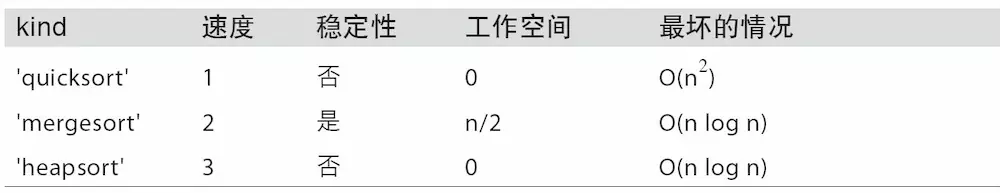

## 数组的部分排序

排序的目标之一可以是确定数组中最大或最小的元素。NumPy已经优化了方法numpy.partition和np.argpartition，用于围绕第k个最小元素对数组进行分区：

In [120]:
np.random.seed(12345)

In [121]:
arr = np.random.randn(20)
arr

array([-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057,
        1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474,
        1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684,
        0.88642934, -2.00163731, -0.37184254,  1.66902531, -0.43856974])

In [122]:
np.partition(arr, 3)

array([-2.00163731, -1.29622111, -0.5557303 , -0.51943872, -0.37184254,
       -0.43856974, -0.20470766,  0.28174615,  0.76902257,  0.47894334,
        1.00718936,  0.09290788,  0.27499163,  0.22891288,  1.35291684,
        0.88642934,  1.39340583,  1.96578057,  1.66902531,  1.24643474])

在调用partition(arr, 3)之后，结果中的前三个元素是最小的三个值，并不是特定的顺序。numpy.argpartition类似于numpy.argsort，它返回的是将数据重新排列为等价顺序的索引：

In [123]:
indices = np.argpartition(arr, 3)
indices

array([16, 11,  3,  2, 17, 19,  0,  7,  8,  1, 10,  6, 12, 13, 14, 15,  5,
        4, 18,  9], dtype=int64)

In [124]:
arr.take(indices)

array([-2.00163731, -1.29622111, -0.5557303 , -0.51943872, -0.37184254,
       -0.43856974, -0.20470766,  0.28174615,  0.76902257,  0.47894334,
        1.00718936,  0.09290788,  0.27499163,  0.22891288,  1.35291684,
        0.88642934,  1.39340583,  1.96578057,  1.66902531,  1.24643474])

## numpy.searchsorted：在已排序的数组中寻找元素

searchsorted是一个数组方法，它对已排序数组执行二分类搜索，返回数组中需要插入值的位置以保持排序：

In [125]:
arr = np.array([0, 1, 7, 12, 15])
arr.searchsorted(9)

3

可以传递一个值数组来获取一个索引数组：

In [126]:
arr.searchsorted([0, 8, 11, 16])

array([0, 3, 3, 5], dtype=int64)

searchsorted方法默认返回**一组相等值最左侧的索引：**

In [31]:
arr = np.array([0,0,0,1,1,1,1])
arr.searchsorted([0,1])

array([0, 3], dtype=int64)

In [128]:
arr.searchsorted([0,1],side='right')

array([3, 7], dtype=int64)

searchsorted的另一个应用：

    假设有一个介于0和10000之间的数值，以及用来分割数据的单独的“箱桶边界”数组；然后可以使用searchsorted得到每个数据点属于哪个区间的标签（其中1代表\[0, 100)\]。

In [129]:
data = np.floor(np.random.uniform(0, 10000, size=50))
bins = np.array([0, 100, 1000, 5000, 10000])
data

array([9940., 6768., 7908., 1709.,  268., 8003., 9037.,  246., 4917.,
       5262., 5963.,  519., 8950., 7282., 8183., 5002., 8101.,  959.,
       2189., 2587., 4681., 4593., 7095., 1780., 5314., 1677., 7688.,
       9281., 6094., 1501., 4896., 3773., 8486., 9110., 3838., 3154.,
       5683., 1878., 1258., 6875., 7996., 5735., 9732., 6340., 8884.,
       4954., 3516., 7142., 5039., 2256.])

In [130]:
labels = bins.searchsorted(data)
labels

array([4, 4, 4, 3, 2, 4, 4, 2, 3, 4, 4, 2, 4, 4, 4, 4, 4, 2, 3, 3, 3, 3,
       4, 3, 4, 3, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4,
       4, 3, 3, 4, 4, 3], dtype=int64)

可以和pandas的groupby一起被用于分箱：

In [131]:
pd.Series(data).groupby(labels).mean()

2     498.000000
3    3064.277778
4    7389.035714
dtype: float64

# 使用Numba编写快速NumPy函数

Numba（ http://numba.pydata.org ）是一个开源项目，可为使用CPU、GPU或其他硬件的NumPy类型的数据创建快速函数。它使用LLVM Project（ http://llvm.org ）将Python代码翻译成编译后的机器码。

为了介绍Numba，先看一个纯Python函数，该函数使用for循环计算表达式(x - y).mean()的值：

In [132]:
import numpy as np
def mean_distance(x, y):
    nx = len(x)
    result = 0.0
    count = 0
    for i in range(len(x)):
        result += x[i] - y[i]
        count += 1
    return result / count

这个函数是很慢的：

In [133]:
x = np.random.randn(10000000)
y = np.random.randn(10000000)

In [134]:
%timeit mean_distance(x, y)

11.8 s ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [135]:
%timeit (x - y).mean()

70.8 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


NumPy的版本要快100倍。可以使用numba.jit函数将这个函数编译成Numba函数：

In [136]:
import numba as nb

In [137]:
numba_mean_distance = nb.jit(mean_distance)

也可以写成装饰器的形式

In [138]:
@nb.jit
def mean_distance(x, y):
    nx = len(x)
    result = 0.0
    count = 0
    for i in range(len(x)):
        result += x[i] - y[i]
        count += 1
    return result / count

结果函数实际上比矢量化的NumPy版本更快：

In [139]:
%timeit numba_mean_distance(x, y)

26.7 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Numba不能编译所有的Python代码，它支持对编写数值算法最有用的纯Python的一个重要子集。Numba库的更多详情请查阅官方文档（ http://numba.pydata.org ）。

## 使用Numba创建自定义numpy.ufunc对象

numba.vectorize函数创建了编译好的NumPy ufunc，其行为也和内建的ufunc类似：

In [33]:
from numba import vectorize

In [35]:
@vectorize
def nb_add(x, y):
    return x + y

然后可以得到：

In [36]:
x = np.arange(10, dtype=np.float64)
nb_add(x, x)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

In [143]:
nb_add.accumulate(x, 0)

array([ 0.,  1.,  3.,  6., 10., 15., 21., 28., 36., 45.])

# 高阶数组输入和输出

先前学习了np.save和np.load，它们用于在磁盘上以二进制格式存储数组。对于更复杂的使用，还有许多其他选项需要考虑。特别是，内存映射有额外的好处，允许处理不适合进入内存的数据集。

## 内存映射文件

内存映射文件是一种与磁盘上的二进制数据交互的方法，就像它是存储在内存数组中一样。NumPy实现了一个memmap对象，它是ndarry型的，允许对大型文件以小堆栈的方式进行读取和写入，而无需将整个数组载入内存。此外，memmap还有和内存数组像同的方法，因此可以特带很多算法中原本要填入的ndarray。

要创建一个新的内存映射，使用np.memmap并传入文件路径、dtype、shape和文件模式：

In [144]:
mmap = np.memmap('C:/Users/lenovo/data_of_python/examples/mymmap',dtype='float64',mode='w+',shape=(10000,10000))
mmap

memmap([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

对memmap切片返回的是硬盘上数据的视图：

In [145]:
section = mmap[:5]

如果将数据赋值给这些切片，他将会在内存中缓存（类似于一个Python文件对象），但可以调用flush将数据写入硬盘：

In [146]:
section[:] = np.random.randn(5,10000)
mmap.flush()
mmap

memmap([[ 1.37140985,  0.93127837,  0.60573747, ..., -0.62115557,
         -0.46780136,  0.47874865],
        [ 0.42296545,  0.83060431,  0.69976547, ...,  1.28831447,
          0.58858679, -1.42755372],
        [ 2.16005954, -1.24616489,  2.44470054, ...,  0.86866129,
          0.28019716,  2.13008671],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [147]:
del mmap

每当内存映射超出范围并且被垃圾回收器回收时，之前的任何更改都将刷新到磁盘。当打开已经存在的内存映射时，任然需要指定dtype和shape，因为这个文件只是磁盘上的一个没有元数据的二进制数据块：

In [148]:
mmap = np.memmap('C:/Users/lenovo/data_of_python/examples/mymmap',dtype='float64',shape=(10000,10000))
mmap

memmap([[ 1.37140985,  0.93127837,  0.60573747, ..., -0.62115557,
         -0.46780136,  0.47874865],
        [ 0.42296545,  0.83060431,  0.69976547, ...,  1.28831447,
          0.58858679, -1.42755372],
        [ 2.16005954, -1.24616489,  2.44470054, ...,  0.86866129,
          0.28019716,  2.13008671],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

内存映射也适用于结构化或嵌套的dtype。

## HDF5和其他数组存储选择

PyTables和h5py是两个为NumPy提供友好接口的Python项目，用于以高效和可压缩的HDF5格式存储数组数据（HDF代表分层数据格式，Hierarchical Data Format）。可以安全地以HDF5格式存储数据百GB或甚至上TB的数据。要了解二更多的信息，请参阅pandas官方文档 （ http://pandas.pydata.org ）。

# 性能技巧

利用NumPy从代码中获得良好性能通常很简单直接，因为数组操作通常会取代相对缓慢的纯Python循环。下面的列表简要总结了一些需要注意的事项：
+ 将Python循环和条件逻辑转换为数组操作和布尔数组操作
+ 尽可能使用广播
+ 使用数组视图（切片）来避免复制数据
+ 使用ufunc和ufunc方法

如果在用尽NumPy提供的功能之后任然无法获得所需的性能，请在C、Fortran或Cython中编写代码。

## 连续内存的重要性

尽管本主题的完整内容超出了本书的范围，但在某些应用中，数组的内存布局会显著影响计算速度。这种情况是基于CPU的缓存层次结构相关的性能差异。访问连续内存快的操作（例如，将C顺序数组的行相加）通常时最快的，因为存储器子系统会将适当的存储器快缓冲到超快的L1或L2 CPU缓存中。此外，NumPy的C代码库中的某些代码路径已进行优化，在连续内存的情况下可以避免对一些跨越式的内存的访问。

如果说数组的内存布局是连续的，就意味着这些元素是按照它们在数组中出现的顺序（即Fortran型（列优先）或C型（行优先））存储在内存中的。默认情况下，NumPy数组是以C顺序连续或只是简单连续的。一个列方向的数组，比如C顺序数组的转置数组，可以称为时Fotran顺序连续的。这些属性都是可以通过ndarray的flags属性来检验的：

In [149]:
arr_c = np.ones((1000, 1000), order='C')
arr_f = np.ones((1000, 1000), order='F')

In [150]:
arr_c.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [151]:
arr_f.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [152]:
arr_f.flags.f_contiguous

True

在这个例子中，这些数组的行以及逆行加和，在理论上是arr_c比arr_f更快，这是因为arr_c的行在内存中是连续的。这里使用IPython中的%timeit进行检查：

In [153]:
%timeit arr_c.sum(1)

1.37 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [154]:
%timeit arr_f.sum(1)

1.33 ms ± 27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


当想从NumPy中挤出更多的性能时，往往需要投入一些努力。如果数组没有所需要的内存顺序，则可以使用copy并传递‘C’或‘F’：

In [155]:
arr_f.copy('C').flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

在数组上构建视图时，请记住结果并不能保证是连续的：

In [156]:
arr_c[:50].flags.contiguous

True

In [157]:
arr_c[:, :50].flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False